This notebook shows examples on the coupled SIA/SSA model with fully rate-and-state-friction-drainage. It also contains a few simple examples on how to read data stored with the hdf5 format

In [1]:
import pyGlacier as pg
import matplotlib.pyplot as plt
import numpy as np
import os
import tables as tb

In [2]:
# Initialize flowline glacier
x = np.linspace(0,2e4,1000)
dx = x[1]-x[0]
b = 2000.0*np.exp(-x/15000)

def SMB(model):
    return (model.b+model.H-1600.0)*1e-3/(365.25*24*60*60)*4

def source_term(model):
    return 1.0e-8*(np.sin(model.t*np.pi/365.25*24*60*60)**2.0)

# Set up variable dictionary:
variables = {
'solver': 
    {'ID': 'coupled',
    'variables':{
        'SMB': SMB,
        'rho': 900.0,
        'g': 9.8,
        'n': 3.0,
        'width': 1.2e3,
        't': 0.0,
        'A': 2.4e-24,
        'H': 0*x,
        'b': b,
        'dx': dx,
        'dt': 1e3},
    'boundaryConditions':{
        'left':{
            'type': 'surface slope',
            'val': 0},
        'right':{
            'type': 'thickness',
            'val': 0} } },
'DrainageSystem': 
    {'ID': 'CoupledConduitCavitySheet',
    'variables': {
        'hydraulic_potential':1000.0*9.8*b + 0*1000.0*1000.0*9.8,
        'latent_heat': 3.0e5,
        'source_term': source_term,
        'water_density': 1000.0,
        'minimum_drainage_thickness': 1.0,
        'S': 0*b,
        'ev': 1.0e-2,
        'percolation_threshold': 0.5,
        'geothermal_heat_flux': 0.0,
        'h0': 0.1,
        'background_conductivity': 1.0e-8,
        'sheet_conductivity': 5.0e-8,
        'channel_constant': 0.01,
        'conduit_spacing': 1000.0,
        'conduit_sheet_contribution': 2.0,
        'ConduitPressure': 'Sheet',
        'closure_coefficient': 5.3e7 } },
'FrictionLaw': 
    {'ID': 'HardBed_RSF',
     'variables':{ 
        'state_parameter': np.zeros(np.size(b)),
        'As': 1.0e-23,
        'm': 3.0,
        'q': 2.5,
        'C': 0.3,
        'tc': 1.0e6,
        'dc': 1.0,
        't_closure_zero_thickness': 1.0e5 } },
'Output': 
    {'ID': 'standard',
    'foldername': 'coupledModel', # By design, the simulation will raise an exeption if this folder exists. This is done to avoid overwriting data if using an existing run-name.
    'output_interval': 30, #will give around 100 time steps per year output
    'reduced': True, # Outputs averaged and min/max quantities over the glacier
    'reduced_output_interval': 10, # Higher resolution average output
    'flush_interval': 1000,
    'file_format': 'hdf5'} }

standard
********** INITIALIZING FLOWLINE **********
Solver: coupled
FrictionLaw: HardBed_RSF
DrainageSystem: CoupledConduitCavitySheet
*******************************************
********** INITIALIZE SIA **********
********** RUN **********
t max: 499.087383070956 years
dt:100000.0 s
**************************
0.9981747661419119 years, dt = 100000.0s
1.9963495322838238 years, dt = 100000.0s
2.994524298425736 years, dt = 100000.0s
3.9926990645676477 years, dt = 100000.0s
4.9908738307095595 years, dt = 100000.0s
5.989048596851472 years, dt = 100000.0s
6.987223362993383 years, dt = 100000.0s
7.985398129135295 years, dt = 100000.0s
8.983572895277208 years, dt = 100000.0s
9.981747661419119 years, dt = 100000.0s
10.979922427561032 years, dt = 100000.0s
11.978097193702943 years, dt = 100000.0s
12.976271959844855 years, dt = 100000.0s
13.974446725986766 years, dt = 100000.0s
14.97262149212868 years, dt = 100000.0s
15.97079625827059 years, dt = 100000.0s
16.968971024412504 years, dt = 100000.

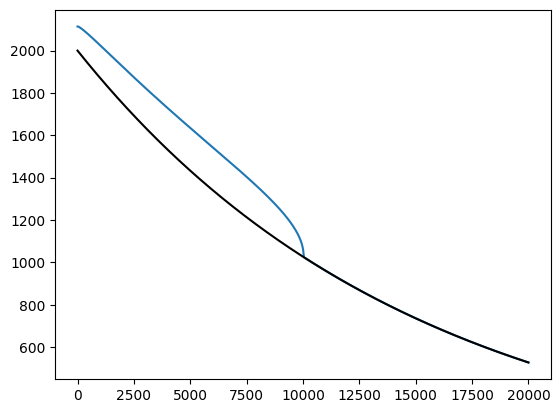

In [4]:
glacier = pg.Flowline(variables = variables)
glacier.runInitializeSIA(dt = 1e5, t_max = 500*3.15e7) # Start simulation with 500 years of SIA

plt.figure()
plt.plot(glacier.x,glacier.H+glacier.b)
plt.plot(glacier.x,glacier.b,'k')
plt.show()

In [5]:
glacier.runAdaptive(t_max = 20*pg.secondyears, dt_min = 10, dt_max = 1e3, error_tolerance = 5e-4, interval = 10) # 20 year simulation

********** RUN ADAPTIVE **********
t max: 20.0 years
dt in [10,1000.0] s
error tolerance: 0.0005
**********************************
0.019510956383354865 years, dt = 1000.0s, rel_error = 3.6730236848530637e-09
0.05119904419738382 years, dt = 1000.0s, rel_error = 5.174626970699964e-09
0.08288713201141276 years, dt = 1000.0s, rel_error = 5.611726404287213e-09
0.11457521982544172 years, dt = 1000.0s, rel_error = 5.833206285272486e-09
0.14626330763947068 years, dt = 1000.0s, rel_error = 5.949788780901975e-09
0.17795139545349964 years, dt = 1000.0s, rel_error = 6.093045499930515e-09
0.20963948326752857 years, dt = 1000.0s, rel_error = 6.253071474821103e-09
0.24132757108155753 years, dt = 1000.0s, rel_error = 6.425863930353866e-09
0.2730156588955865 years, dt = 1000.0s, rel_error = 6.597190540545451e-09
0.3047037467096154 years, dt = 1000.0s, rel_error = 6.758249343390689e-09
0.3363918345236444 years, dt = 1000.0s, rel_error = 6.951407165018838e-09
0.36807992233767334 years, dt = 1000.0s, rel

0

Now that the run has finished, we can open the file. The default location is "yourFoldername/data/out.h5", which is split in data.root.INIT, data.root.full and data.root.average

There is also an src folder created where the run script is copied. Note that this particular feature is currently not compatible with the use of jupyter.

In [6]:
data = tb.open_file(variables['Output']['foldername'] + '/data/out.h5')
x = [x/1000 for x in data.root.INIT.x]
t = [x/pg.secondyears for x in data.root.full.t]
t_ave = [x/pg.secondyears for x in data.root.average.t]
H = [x for x in data.root.full.H]
H_ave = [x for x in data.root.average.H]
U = [x*pg.secondyears  for x in data.root.full.U]
U_SSA = [x*pg.secondyears  for x in data.root.full.U_SSA]
U_SIA = [x*pg.secondyears  for x in data.root.full.U_SIA]
sliding_velocity = [x*pg.secondyears  for x in data.root.full.sliding_velocity]
U_ave = [x*pg.secondyears for x in data.root.average.U]
pw = [x/1e6 for x in data.root.full.water_pressure]
pw_ave = [x/1e6 for x in data.root.average.water_pressure]
theta = [x for x in data.root.full.state_parameter]
theta_ave = [x for x in data.root.average.state_parameter]
S_ave = [x for x in data.root.average.S]
S = [x for x in data.root.full.S]

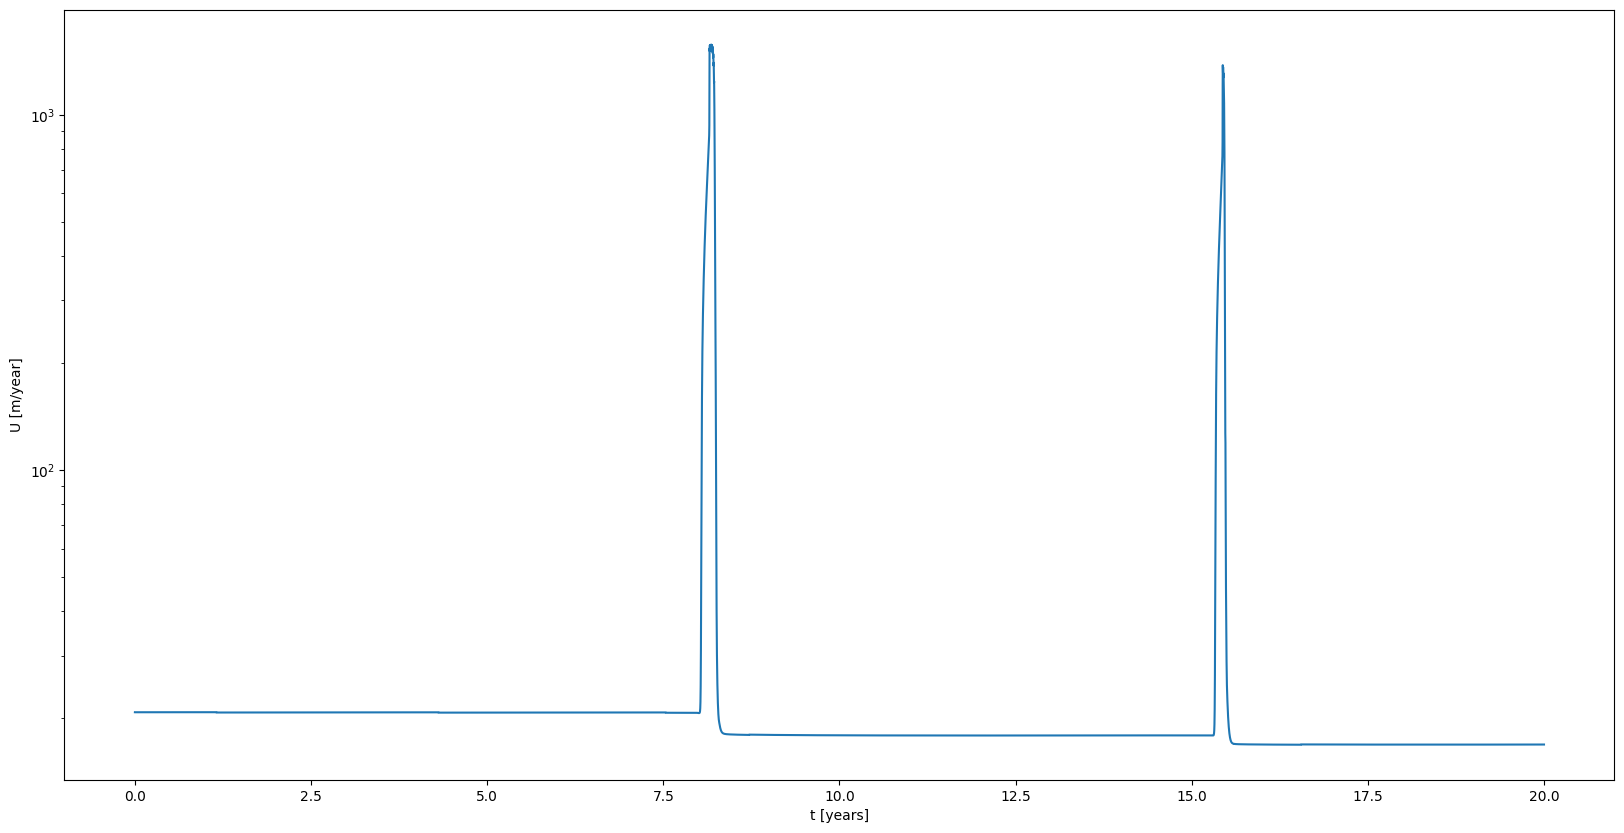

In [7]:
plt.figure(figsize = (20,10))
plt.plot(t_ave,U_ave)
plt.yscale('log')
plt.xlabel('t [years]')
plt.ylabel('U [m/year]')
plt.show()

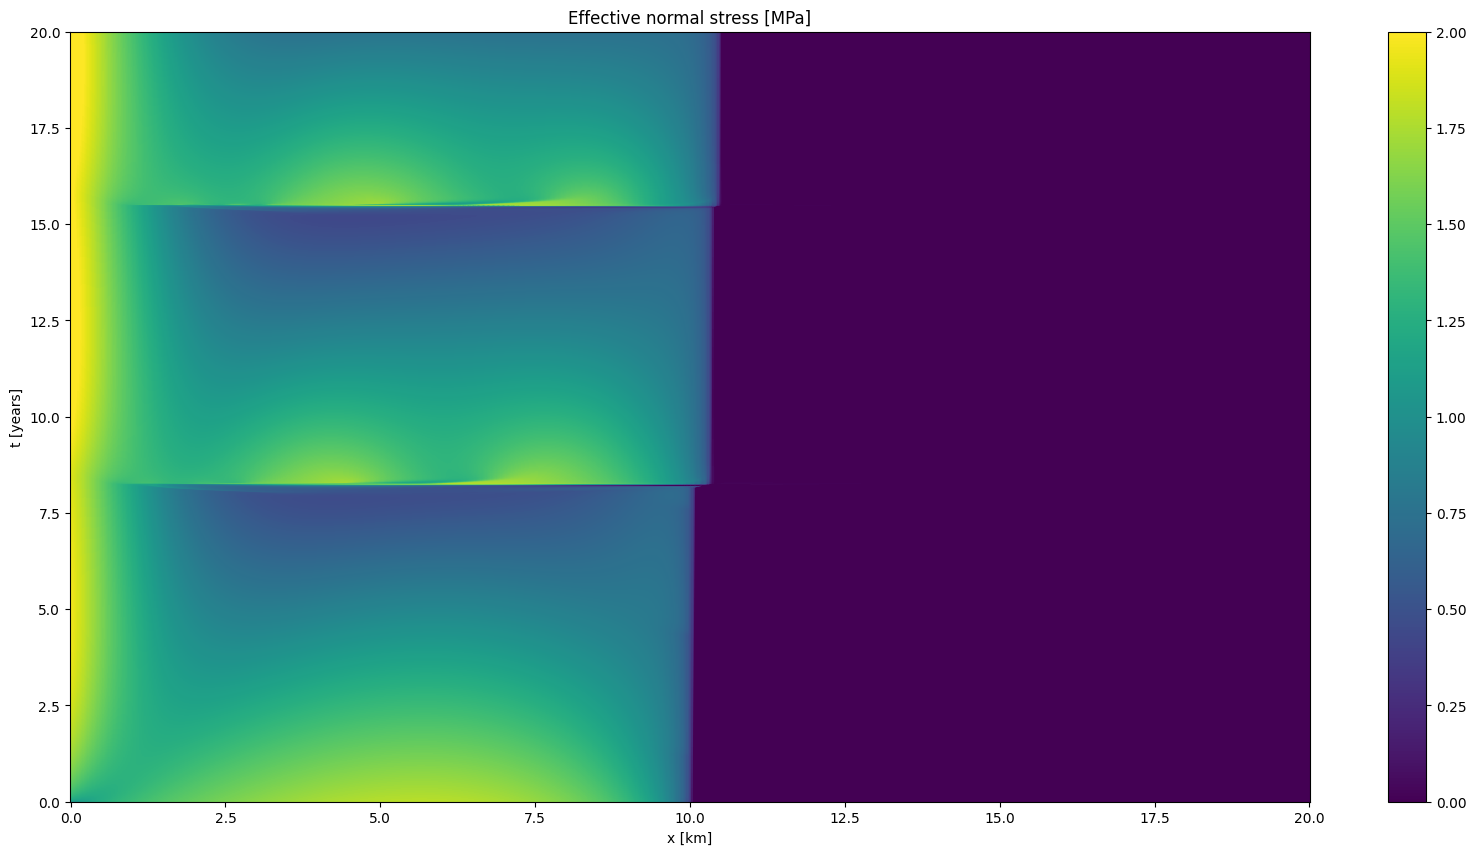

In [8]:
plt.figure(figsize = (20,10))
plt.pcolormesh(x,t,9.8*900*np.array(H)/1e6-np.array(pw),shading='auto')
plt.clim([0,2])
plt.colorbar()
plt.title('Effective normal stress [MPa]')
plt.xlabel('x [km]')
plt.ylabel('t [years]')
plt.show()

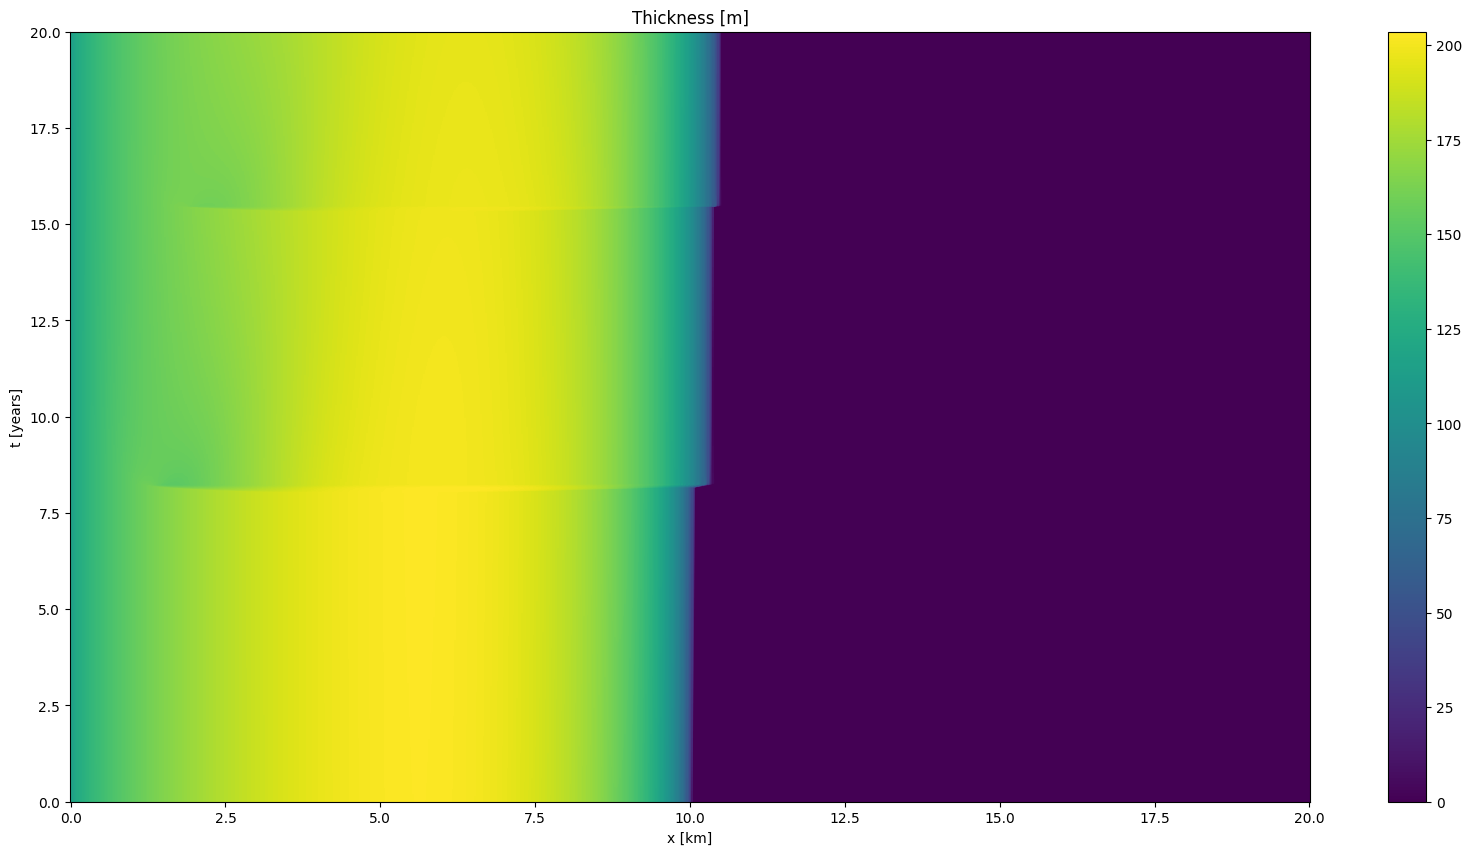

In [9]:
plt.figure(figsize = (20,10))
plt.pcolormesh(x,t,np.array(H),shading='auto')
plt.colorbar()
plt.title('Thickness [m]')
plt.xlabel('x [km]')
plt.ylabel('t [years]')
plt.show()